In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from unidecode import unidecode
import warnings
pd.set_option('display.max_columns',30)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from scipy.stats import randint,uniform

# Load Data

In [5]:
men_shoes = pd.read_csv('../vietnamese_tiki_products_men_shoes.csv')
women_shoes = pd.read_csv('../vietnamese_tiki_products_women_shoes.csv')

men_shoes = men_shoes.drop(columns=['Unnamed: 0'])
women_shoes = women_shoes.drop(columns=['Unnamed: 0'])

In [6]:
#I add tag 'men' / 'women' into category_name to ensure that there are no identical category name in both table when concatenated later
men_shoes['category'] = 'men'
women_shoes['category'] = 'women'

In [7]:
shoes = pd.concat([men_shoes,women_shoes])
shoes = shoes.reset_index().drop(columns='index')
shoes = shoes.drop_duplicates(subset=['id'])

In [8]:
shoes.sample(3)

,id,name,description,original_price,price,fulfillment_type,brand,review_count,rating_average,favourite_count,pay_later,current_seller,date_created,number_of_images,vnd_cashback,has_video,category,quantity_sold
9855,112959337,Sandal 5p gót bầu thời trang quai trong 21340,Sandal 5p gót bầu 21340 THÔNG TIN SẢN...,299800,263500,dropship,ĐỒ DA THÀNH LONG TLG,0,0.0,0,True,ĐỒ DA THÀNH LONG TLG,789,9,7010,False,women,0
7277,249197762,Dép kẹp nam xỏ ngón nữ(dép cặp) size nam từ 36...,...,165000,165000,dropship,OEM,0,0.0,0,True,LYNA Sandal,166,5,4420,False,women,0
9454,76406885,Dép Nữ Đế Xuồng BIGGBEN Cao Cấp DX27,Dép Nữ với chất liệu da bò bền đẹp dép êm nhẹ ...,450000,249000,dropship,BIGGBEN,4,5.0,0,True,Shoes BIGBEN,952,4,0,False,women,4


# Processing Data

In [9]:
shoes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11661 entries, 0 to 11663
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                11661 non-null  int64  
 1   name              11661 non-null  object 
 2   description       11661 non-null  object 
 3   original_price    11661 non-null  int64  
 4   price             11661 non-null  int64  
 5   fulfillment_type  11660 non-null  object 
 6   brand             11661 non-null  object 
 7   review_count      11661 non-null  int64  
 8   rating_average    11661 non-null  float64
 9   favourite_count   11661 non-null  int64  
 10  pay_later         11661 non-null  bool   
 11  current_seller    11661 non-null  object 
 12  date_created      11661 non-null  int64  
 13  number_of_images  11661 non-null  int64  
 14  vnd_cashback      11661 non-null  int64  
 15  has_video         11661 non-null  bool   
 16  category          11661 non-null  object 
 17

In [10]:
shoes['brand'] = shoes['brand'].replace('\tOEM','OEM')
shoes['estimated_revenue'] = shoes['price']*shoes['quantity_sold']
shoes['discount_rate'] = (shoes['original_price'] - shoes['price']) / shoes['original_price']

In my investigation of item name, I found out that there are a number of products which are actually not shoes but classified in shoes category(both men's and women's shoes category)
Therefore we should exclude those items not relevant

In [11]:
relevant_keyword = ['giay', 'dep', 'boot', 'boots', 'guoc','xuc', 'suc', 'sandal','sandals', 'got', 'xang dan',
                   'sandan', 'chai', 've sinh', 'dung', 'bot', 'sneaker', 'sneakers', 'ung','tong','crocs',
                   'marten']
ascii_keywords = [unidecode(word) for word in relevant_keyword]

# apply to unicode characters
shoes['name_unicode'] = shoes['name'].str.lower().apply(unidecode)
shoes['description_unicode'] = shoes['description'].str.lower().apply(unidecode)

# Include only instances that title or description has relevant_keyword of shoes
shoes = shoes.loc[((shoes['name_unicode'].str.contains('|'.join(ascii_keywords))) | (shoes['description_unicode'].str.contains('|'.join(ascii_keywords))))]

shoes = shoes.drop(columns=['description_unicode','name_unicode'])

In [12]:
shoes.shape

(11610, 20)

# Data Summary 

In [13]:
shoes.columns

Index(['id', 'name', 'description', 'original_price', 'price',
       'fulfillment_type', 'brand', 'review_count', 'rating_average',
       'favourite_count', 'pay_later', 'current_seller', 'date_created',
       'number_of_images', 'vnd_cashback', 'has_video', 'category',
       'quantity_sold', 'estimated_revenue', 'discount_rate'],
      dtype='object')

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/1217905380.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/1217905380.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/1217905380.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)


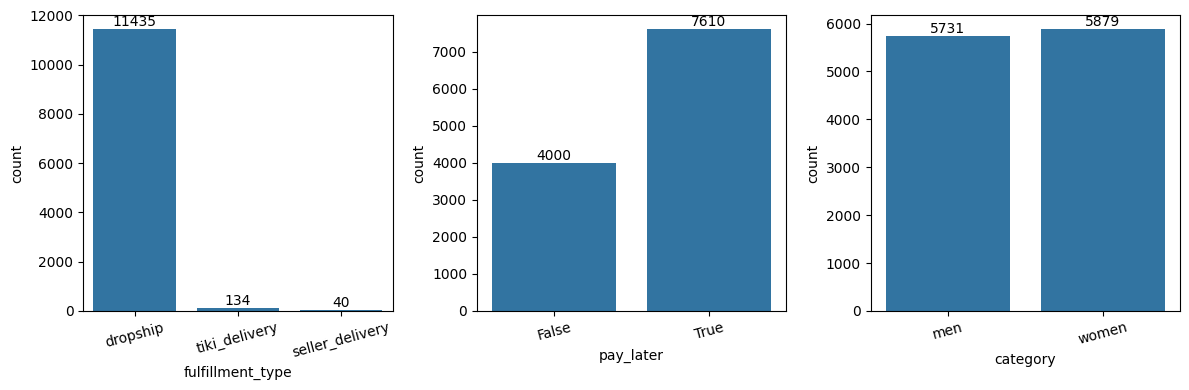

In [14]:
cat_cols = ['fulfillment_type', 'pay_later', 'category']
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

for col, ax in zip(cat_cols, axes.ravel()):
    sns.countplot(data=shoes, x=col, ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

plt.tight_layout()

- 'fulfillment_type': dropship is the dominant fulfillment type in these category. Dropship means the sellers send products to TIKI then TIKI takes care of delivery. TIKI_delivery means the sellers give products priorly to TIKI warehouse (consignment selling) then TIKI takes care of all afterward delivery. seller_delivery means the sellers send goods directly to customers themselves. Cross_border means selling overseas
- 'Pay_later': It is surpring that low-price, common products like shoes having pay_later policy available. I think that this is an 'add-on service' only and it does not have any usability here as a role of customer

In [15]:
px.histogram(shoes,x='discount_rate',nbins=20,marginal='box')

In [16]:
px.histogram(shoes,x='vnd_cashback',nbins=20,marginal='rug')

In [17]:
top_product_count_sellers = shoes['current_seller'].value_counts().nlargest(15)
fig = px.bar(top_product_count_sellers, x=top_product_count_sellers.index, y=top_product_count_sellers.values)
fig.update_layout(title='Top sellers with most count products (sellers take priority in buy-box)')

- This is the top sellers that win the most buy-box. In TIKI showing items'mechanism, many sellers can list the same item with the same product ID. The seller offers a product better will win the buy-box and takes the advantage of selling that identical product.
- In this analysis, we can see that TLG GOLD / Đồ Da Thành Long TLG are two stores with the same company
Giày Chất Store / Chất Store 247 is the same.

In [18]:
top_revenue_sellers = shoes.groupby('current_seller')['estimated_revenue'].sum().nlargest(15)

fig = px.bar(top_revenue_sellers, x=top_revenue_sellers.index, y='estimated_revenue')
fig.update_layout(title='Top Sellers by Estimated Revenue')
fig.show()


- Although the top sellers such as TLG GOLD, Chất Store have the most products listed, they are not in top revenue sellers.

- 1st rank Shoes BIGBEN: this store sells leather shoes for men and women with | price range 250k - 400k
- 2nd rank WearVN: this seller is official distributor of CONVERSE footwears | price range from over 1.2m
- 3rd rank ZAVAS Flagship Store: this is local brand with main products are fashion sneakers | price range from 300k - 500k

# COMPARISON BETWEEN TWO ROOT CATEGORY

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/4083701694.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/4083701694.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/4083701694.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



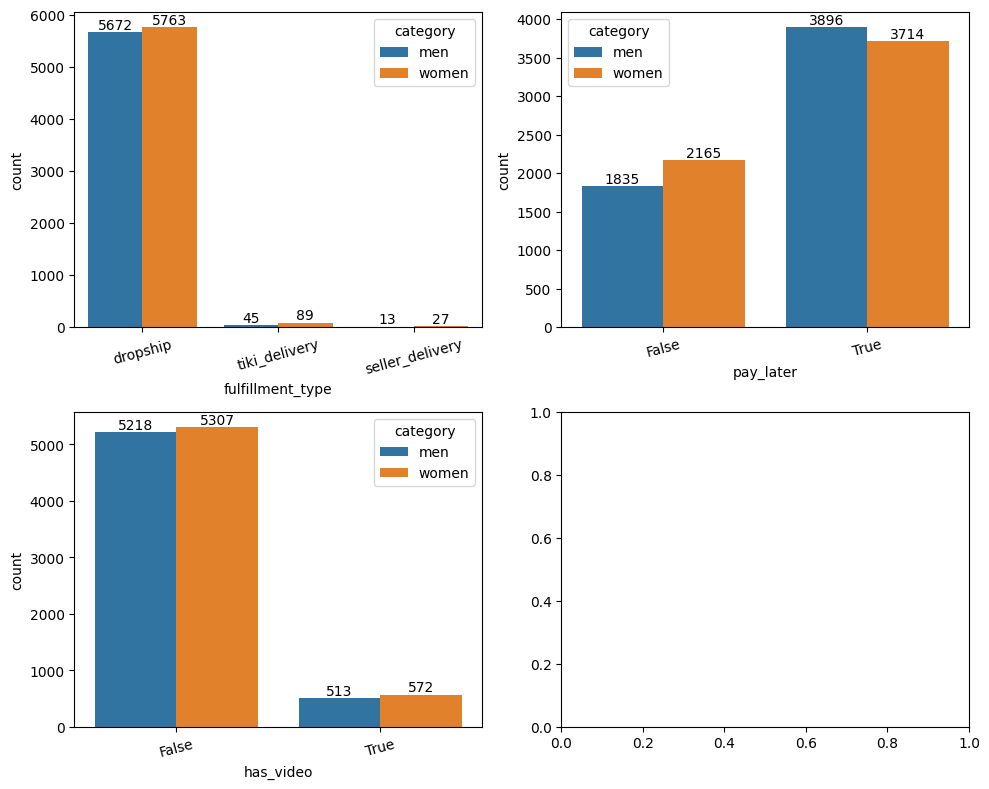

In [19]:
cat_cols = ['fulfillment_type', 'pay_later', 'has_video']
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)

for col, ax in zip(cat_cols, axes.ravel()):
    sns.countplot(data=shoes, x=col, ax=ax, hue='category')
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

plt.tight_layout()

We can see in the overview chart comparing men's and women' shoes that women's shoes dominates in most counting because the women's product id is much higher than men's id

# Variables Analysis

For the machine learning task, I will try to predict quantity_sold based on the data being crawled

Moreover, predicting sales per week, sales per day is more practical than predicting alltime sold.

In [20]:
cols = ['price','brand','review_count','rating_average','pay_later','date_created',
        'category','has_video','vnd_cashback','number_of_images','discount_rate','quantity_sold']
model_df = shoes[cols]

In [21]:
model_df.shape

(11610, 12)

In [22]:
model_df.sample(3)

,price,brand,review_count,rating_average,pay_later,date_created,category,has_video,vnd_cashback,number_of_images,discount_rate,quantity_sold
216,67000,OEM,1,5.0,False,945,men,False,0,7,0.00,2
3858,47000,B21 B21 SHOEMAKER,0,0.0,False,465,men,False,1258,12,0.00,0
9945,408000,Biti's,6,5.0,True,440,women,False,0,7,0.15,22


In [23]:
model_df[['pay_later','has_video']] = model_df[['pay_later','has_video']].astype(int)

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/916936741.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
model_df.describe(include='all')

,price,brand,review_count,rating_average,pay_later,date_created,category,has_video,vnd_cashback,number_of_images,discount_rate,quantity_sold
count,1.161000e+04,11610,11610.000000,11610.000000,11610.000000,11610.000000,11610,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000
unique,NaN,237,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,OEM,NaN,NaN,NaN,NaN,women,NaN,NaN,NaN,NaN,NaN
freq,NaN,8370,NaN,NaN,NaN,NaN,5879,NaN,NaN,NaN,NaN,NaN
mean,3.284897e+05,NaN,3.879242,1.632283,0.655469,631.599655,NaN,0.093454,1791.145306,6.069509,0.065914,19.474763
std,5.852722e+05,NaN,21.347235,2.192567,0.475235,366.462635,NaN,0.291080,8529.943407,2.984655,0.144379,139.607787
min,1.900000e+03,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000
25%,7.500000e+04,NaN,0.000000,0.000000,0.000000,365.000000,NaN,0.000000,0.000000,4.000000,0.000000,0.000000
50%,1.699990e+05,NaN,0.000000,0.000000,1.000000,580.000000,NaN,0.000000,0.000000,6.000000,0.000000,1.000000
75%,3.056000e+05,NaN,2.000000,4.500000,1.000000,810.000000,NaN,0.000000,0.000000,8.000000,0.000000,6.000000


In [25]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11610 entries, 0 to 11663
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             11610 non-null  int64  
 1   brand             11610 non-null  object 
 2   review_count      11610 non-null  int64  
 3   rating_average    11610 non-null  float64
 4   pay_later         11610 non-null  int64  
 5   date_created      11610 non-null  int64  
 6   category          11610 non-null  object 
 7   has_video         11610 non-null  int64  
 8   vnd_cashback      11610 non-null  int64  
 9   number_of_images  11610 non-null  int64  
 10  discount_rate     11610 non-null  float64
 11  quantity_sold     11610 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1.2+ MB


In [26]:
# There are total of 237 brands, I will convert product with brand count <10 into OEM because these brands are so minor and unrecognizable
# Treated them as OEM would be a better choice

brand_counts = shoes['brand'].value_counts()
brands_less_than_10 = brand_counts[brand_counts < 10].index.tolist()

model_df['brand'] = model_df['brand'].apply(lambda x: 'OEM' if x in brands_less_than_10 else x)

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/2438343556.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
fig = px.histogram(model_df,x='price',marginal='box')
fig.update_layout(title='histogram of price')

In [28]:
# Create the histogram with a box plot on the marginal axis
fig = px.histogram(
    x=model_df['price'].apply(lambda x: np.log1p(x)),  # Apply np.log1p to the 'price' column
    marginal='box'
)

# Update the layout and set the title
fig.update_layout(
    title='Histogram of the Logarithm of Price',
    xaxis_title='Log(Price)'  # Set the x-axis label if needed
)

# Show the plot
fig.show()


In [29]:
#Remove Outliers based on IQR of Log(price)
model_df['log1price'] = np.log1p(model_df['price'])
model_df = model_df.loc[(model_df['log1price']<14.73) & (model_df['log1price'] > 9.15)]
model_df = model_df.drop('log1price',axis=1)  

/var/folders/0z/9ctsbk397rqc2kl_dplkdsr00000gn/T/ipykernel_46893/1265713854.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
fig = px.histogram(model_df,x='review_count',marginal='box')
fig.update_layout(title='histogram of review counts')

fig.add_annotation(
    x=10, y=500,  
    text = 'most review counts = 0',
    showarrow=True,  # show an arrow pointing to the annotation
    arrowhead=1,  # style of the arrowhead
    ax=100,  # x-coordinate of the arrowhead
    ay=-150,  # y-coordinate of the arrowhead
)

In [31]:
fig = px.histogram(model_df, x='rating_average', marginal='box')
fig.update_layout(title='Histogram of Average Rating')

fig.add_annotation(
    x=0.1, y=1000,
    text='Average rating is 0 because there are no reviews yet. Log transform is also not good',
    showarrow=True,
    arrowhead=1,
    ax=100,
    ay=-150,
    align='left'
)

In [32]:
fig = px.histogram(model_df,x='vnd_cashback',marginal='box')
fig.update_layout(title='histogram of vnd cashback')

In [33]:
fig = px.histogram(model_df['quantity_sold'],marginal='box')
fig.update_layout(title='histogram of logarit of vnd cashback')

In [34]:
fig = px.histogram(np.log1p(model_df['quantity_sold']),marginal='box')
fig.update_layout(title='histogram of logarit of vnd cashback')
fig.add_annotation(
    text='log transform is not good for this case'
)

<Axes: >

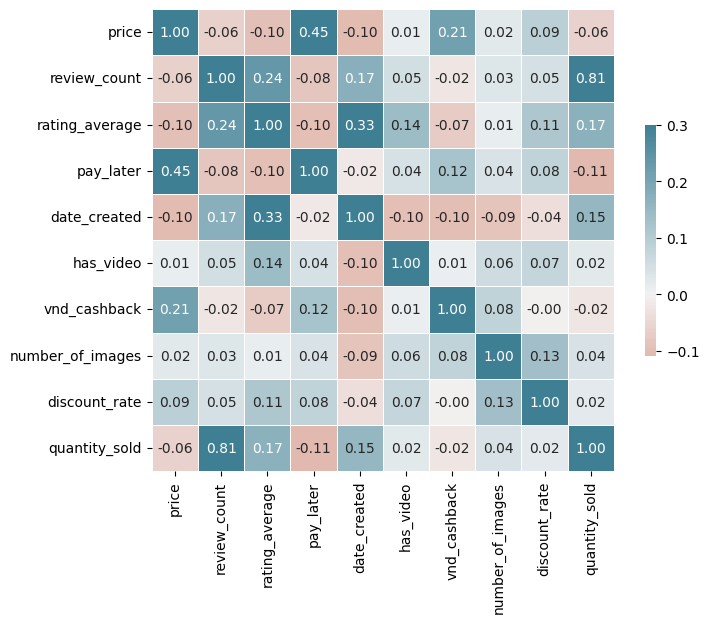

In [35]:
categorical_columns = model_df.select_dtypes(include=['object', 'category']).columns

# Exclude categorical columns from the DataFrame before calculating correlations
numerical_df = model_df.drop(columns=categorical_columns)

# Calculate correlations for numerical columns
corr = numerical_df.corr(method='pearson')

plt.figure(figsize=(8,6))
palette = sns.diverging_palette(20, 220, n=256)

sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlation of features are not high.
Especially, review counts has very strong correlation to quantity_sold

In [36]:
!pip install lazypredict -q

# Building Model

In [37]:
model_df_ohe = pd.get_dummies(model_df)

X = model_df_ohe.drop(columns='quantity_sold')
y = model_df_ohe['quantity_sold']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=10)

In [38]:
mms = MinMaxScaler()
mms.fit(X_train)

X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

In [39]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

lazy_regressor = LazyRegressor()

# Fit the models and evaluate with X_train_scaled and y_train
models, predictions = lazy_regressor.fit(X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test)


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HuberRegressor,0.73,0.74,38.69,2.40
LinearSVR,0.72,0.73,38.99,3.53
ElasticNet,0.71,0.72,39.89,0.16
TweedieRegressor,0.68,0.69,42.05,0.20
GradientBoostingRegressor,0.66,0.68,42.86,1.77
DecisionTreeRegressor,0.65,0.66,43.78,0.24
ElasticNetCV,0.62,0.64,45.54,1.02
PassiveAggressiveRegressor,0.58,0.60,47.99,0.28
RandomForestRegressor,0.57,0.59,48.50,7.84


In [ ]:
predictions